# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project: Donor Leads through Networks


--- 

By: Wenzhe

## Network Preparation & Exploration

### Overview

This notebook uses the scraped data in dataframe and creates the network graph and stores it in JSON. It also briefly explores some visualisations based on the network.

### Notebook Structure

* [Part 1: Node Creation](#part-1-node-creation)
* [Part 2: Edge Creation](#part-2-edge-creation)
* [Part 3: Visualisation Exploration](#part-3-visualisation-exploration)
* [Part 4: Saving the Graph Data](#part-4-saving-the-graph-data)

---

## Part 1: Node Creation

#### Import Libraries & Setup

In [1]:
#!pip install networkit

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# NetworkX to create and work with Networks
import networkx as nx

# Pyvis to visualise the graps from NetworkX 
from pyvis.network import Network

# To write the graph data into JSON
import json
from networkx.readwrite import json_graph

# For forest centrality
import networkit

In [3]:
# initialise an empty graph
G = nx.Graph()

In [4]:
# Function to add nodes to the graph
def add_nodes_to_graph(graph, dictionary):
    for node, attr in dictionary.items():
        graph.add_node(node, **attr)

### Person Nodes

In [5]:
# make the index str type
# persons_dtypes = {'index': str}

In [6]:
# charities = pd.read_csv('../raw_data/charities_info.csv')
# persons = pd.read_csv('../data/persons.csv', dtype=persons_dtypes)
persons = pd.read_csv('../data/persons.csv')

In [7]:
persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31652 entries, 0 to 31651
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          31652 non-null  object
 1   role          31652 non-null  object
 2   designation   31223 non-null  object
 3   charity_name  31652 non-null  object
 4   charity_uen   31652 non-null  object
 5   index         31652 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


Add a `node-type` attribute to mark all person nodes.

In [8]:
persons['node-type'] = 'person'

Convert persons dataframe into a dictionary to add to network. Index will be the key for each node and the remaining details are stored in a dictionary.

In [9]:
# persons.set_index('index').T.apply(tuple).to_dict()
dict_persons = persons.set_index('index').T.to_dict('dict')
dict_persons

{0: {'name': 'HO HOU CHIAT, ISAAC',
  'role': 'Board Member',
  'designation': 'DIRECTOR',
  'charity_name': '#CHECKED LIMITED',
  'charity_uen': '200920810R',
  'node-type': 'person'},
 1: {'name': 'LU SHAN-JUI',
  'role': 'Board Member',
  'designation': 'DIRECTOR',
  'charity_name': '#CHECKED LIMITED',
  'charity_uen': '200920810R',
  'node-type': 'person'},
 2: {'name': 'ZHOU LIHAN',
  'role': 'Board Member',
  'designation': 'DIRECTOR',
  'charity_name': '#CHECKED LIMITED',
  'charity_uen': '200920810R',
  'node-type': 'person'},
 3: {'name': 'SUN YIK CHEN',
  'role': 'Key Officer',
  'designation': 'CORPORATE SECRETARY',
  'charity_name': '#CHECKED LIMITED',
  'charity_uen': '200920810R',
  'node-type': 'person'},
 4: {'name': 'RAMESH S/O KUMAR',
  'role': 'Board Member',
  'designation': 'DIRECTOR',
  'charity_name': '*SCAPE CO., LTD.',
  'charity_uen': '200712761D',
  'node-type': 'person'},
 5: {'name': 'TAN LIN TECK',
  'role': 'Board Member',
  'designation': 'DIRECTOR',
  '

In [10]:
add_nodes_to_graph(G, dict_persons)

In [11]:
# Check that all persons have been added to the graph
len(G.nodes)

31652

### Charity Nodes

Repeat the steps for charities instead, but using UEN as the key instead.

In [12]:
# Declare a type for postal code column to preserve string format
data_types = {'postal_code': str}

In [13]:
charities = pd.read_csv('../data/charities.csv', dtype=data_types)

In [14]:
charities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2601 entries, 0 to 2600
Data columns (total 68 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   charity_uen                                            2601 non-null   object
 1   charity_name                                           2601 non-null   object
 2   address                                                2598 non-null   object
 3   postal_code                                            2535 non-null   object
 4   charity_objective                                      2274 non-null   object
 5   charity_vision                                         2115 non-null   object
 6   sector                                                 2601 non-null   object
 7   is_ipc                                                 2601 non-null   int64 
 8   activity_direct_services                               260

In [15]:
# set the node-type of charities to be entity instead of person
charities['node-type'] = 'entity'

In [16]:
# Make a numeric index for charities as karateclub requires numeric nodes
charities['index'] = charities.index + 40000

In [17]:
dict_charities = charities.set_index('index').T.to_dict('dict')
dict_charities

{40000: {'charity_uen': '200920810R',
  'charity_name': '#CHECKED LIMITED',
  'address': '350 ORCHARD ROAD, #17-07/09, SHAW HOUSE, 238868',
  'postal_code': '238868',
  'charity_objective': 'A. To match Green innovation ideas with the relevant resources. B. To instill resource management values to Corporates, Youths and Children. C. To impart green values through Service Learning using Arts as a medium. D. To organize competitions with green themes as awareness campaigns. E. To be the leading green events organizer.',
  'charity_vision': '1. Vision: To be an educational platform for effective Green Innovation for Active learners and Corporate leaders. 2. Mission: A. To match Green innovation ideas with the relevant resources. B. To instill resource management values to Corporates, Youths and Children. C. To impart green values through Service Learning using Arts as a medium. D. To organize competitions with green themes as awareness campaigns. E. To be the leading green events organize

In [18]:
add_nodes_to_graph(G, dict_charities)

In [19]:
# Verify charity nodes added to graph
len(G.nodes)

34253

---

## Part 2: Edge Creation

Create an edge between the person and the charity based on the `persons` dataframe.

In [20]:
persons_char_index = pd.merge(persons, charities[['charity_uen', 'index']], on='charity_uen', how='left')

In [21]:
persons_char_index.head()

name          role          designation      charity_name  \
0  HO HOU CHIAT, ISAAC  Board Member             DIRECTOR  #CHECKED LIMITED   
1          LU SHAN-JUI  Board Member             DIRECTOR  #CHECKED LIMITED   
2           ZHOU LIHAN  Board Member             DIRECTOR  #CHECKED LIMITED   
3         SUN YIK CHEN   Key Officer  CORPORATE SECRETARY  #CHECKED LIMITED   
4     RAMESH S/O KUMAR  Board Member             DIRECTOR  *SCAPE CO., LTD.   

  charity_uen  index_x node-type  index_y  
0  200920810R        0    person    40000  
1  200920810R        1    person    40000  
2  200920810R        2    person    40000  
3  200920810R        3    person    40000  
4  200712761D        4    person    40001

In [22]:
# list_persons_tuple = list(zip(persons['index'], persons['charity_uen']))
list_persons_tuple = list(zip(persons_char_index['index_x'], persons_char_index['index_y']))
list_persons_tuple

[(0, 40000),
 (1, 40000),
 (2, 40000),
 (3, 40000),
 (4, 40001),
 (5, 40001),
 (6, 40001),
 (7, 40001),
 (8, 40001),
 (9, 40001),
 (10, 40001),
 (11, 40001),
 (12, 40001),
 (13, 40001),
 (14, 40001),
 (15, 40001),
 (16, 40001),
 (17, 40001),
 (18, 40001),
 (19, 40001),
 (20, 40001),
 (21, 40001),
 (22, 40001),
 (23, 40002),
 (24, 40002),
 (25, 40002),
 (26, 40002),
 (27, 40002),
 (28, 40002),
 (29, 40003),
 (30, 40003),
 (31, 40003),
 (32, 40003),
 (33, 40003),
 (34, 40003),
 (35, 40003),
 (36, 40003),
 (37, 40003),
 (38, 40003),
 (39, 40003),
 (40, 40003),
 (41, 40003),
 (42, 40003),
 (43, 40003),
 (44, 40004),
 (45, 40004),
 (46, 40004),
 (47, 40004),
 (48, 40004),
 (49, 40005),
 (50, 40005),
 (51, 40005),
 (52, 40005),
 (53, 40005),
 (54, 40005),
 (55, 40005),
 (56, 40005),
 (57, 40005),
 (58, 40005),
 (59, 40005),
 (60, 40005),
 (61, 40005),
 (62, 40006),
 (63, 40006),
 (64, 40006),
 (65, 40006),
 (66, 40006),
 (67, 40006),
 (68, 40006),
 (69, 40006),
 (70, 40006),
 (71, 40007),
 (

In [23]:
G.add_edges_from(list_persons_tuple)

Function to merge nodes and maintain all edges that were previously connected

In [24]:
def merge_nodes_keep_edges(G, nodes):
    # keep the smallest id as the node
    node_kept = min(nodes)
    print(f"Keeping node {node_kept} as the main node")

    for node in nodes:
        if node != node_kept:
            list_to_edge = []
            for edge_to in list(G.edges(node)):
                list_to_edge.append((node_kept, edge_to[1]))
                print(f"Adding edge {edge_to[1]} to {node_kept}, originally from {node}")
            G.add_edges_from(list_to_edge)
            G.remove_node(node)
            print(f"Removing node {node}")

    

Merge all person nodes when they have the exact same name

In [25]:
for name in set(nx.get_node_attributes(G, 'name').values()):
    #nodes_to_merge = [node for node, data in G.nodes(data=True) if data['node-type'] == 'person' and data['name'] == name]
    same_person = [node for node, data in G.nodes(data=True) if data.get('node-type') == 'person' and data.get('name')== name]
    if len(same_person) > 1:
        merge_nodes_keep_edges(G, same_person)

Keeping node 14462 as the main node
Adding edge 41234 to 14462, originally from 14476
Removing node 14476
Keeping node 21281 as the main node
Adding edge 41782 to 21281, originally from 21286
Removing node 21286
Keeping node 29618 as the main node
Adding edge 42448 to 29618, originally from 29625
Removing node 29625
Adding edge 42450 to 29618, originally from 29631
Removing node 29631
Keeping node 20304 as the main node
Adding edge 41706 to 20304, originally from 20306
Removing node 20306
Keeping node 12640 as the main node
Adding edge 41084 to 12640, originally from 12646
Removing node 12646
Keeping node 16982 as the main node
Adding edge 42300 to 16982, originally from 27720
Removing node 27720
Keeping node 31094 as the main node
Adding edge 42558 to 31094, originally from 31100
Removing node 31100
Keeping node 19872 as the main node
Adding edge 41664 to 19872, originally from 19879
Removing node 19879
Keeping node 21936 as the main node
Adding edge 41833 to 21936, originally from 21

Keeping node 7678 as the main node
Adding edge 40746 to 7678, originally from 8507
Removing node 8507
Adding edge 41407 to 7678, originally from 16644
Removing node 16644
Adding edge 42497 to 7678, originally from 30217
Removing node 30217
Adding edge 42497 to 7678, originally from 30222
Removing node 30222
Keeping node 7346 as the main node
Adding edge 40639 to 7346, originally from 7353
Removing node 7353
Keeping node 13439 as the main node
Adding edge 41148 to 13439, originally from 13449
Removing node 13449
Keeping node 23878 as the main node
Adding edge 41971 to 23878, originally from 23884
Removing node 23884
Keeping node 24556 as the main node
Adding edge 42018 to 24556, originally from 24563
Removing node 24563
Keeping node 3492 as the main node
Adding edge 40455 to 3492, originally from 5537
Removing node 5537
Keeping node 15885 as the main node
Adding edge 42157 to 15885, originally from 26175
Removing node 26175
Keeping node 20217 as the main node
Adding edge 41696 to 20217,

---

## Part 3: Visualisation Exploration

Explore some visualisations of a network graph.

In [26]:
# remap the labels of nodes to be continuous to allow for modelling
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

In [27]:
# Returns the name of person / charity
def label_node_name(node):
    if node.get('node-type') == 'person':
        return node.get('name')
    else:
        return node.get('charity_name')

In [28]:
# make persons dot and charities square on the visualisation
def label_node_shape(node):
    if node['node-type'] == 'person':
        return 'dot'
    else:
        return 'box' # square

In [29]:
# Add the label and shape to nodes
for n in G.nodes(data=True):
    n[1]['label'] = label_node_name(n[1])
    n[1]['shape'] = label_node_shape(n[1])

In [30]:
def visualise_graph(graph, filename):
    for n in graph.nodes(data=True):
        n[1]['label'] = label_node_name(n[1])
        n[1]['shape'] = label_node_shape(n[1])
    
    # step#3: Draw the network using pyvis
    pyvis_net = Network(notebook=True, cdn_resources='remote') # instantiate an object of Network class from pyvis. only specify notebook=True for running in a jupyter notebook. 
    pyvis_net.from_nx(graph) # to visualize a network from NetworkX using pyvis (pass in NetworkX graph object from step#2)
    #pyvis_net.show_buttons(filter_=['physics'])
    pyvis_net.show(f'../graph/{filename}.html') # to display network and auto save network viz to a html file that's saved into current directory (we're naming this network viz 'g1' but we can customize to anything)

In [31]:
# Returns the node of a charity based on its name
# Names are unique, else returns the first instance
def get_charity_by_name(G, name):
    node_select = [node for node, data in G.nodes(data=True) if data.get('node-type') == 'entity' and data.get('charity_name') == name]
    # return none if no such charity name
    if len(node_select) == 0: return None
    return node_select[0]

In [32]:
charity_nodes = [node for node, data in G.nodes(data=True) if data.get('node-type') == 'entity']
charity_names = [data.get('charity_name') for node, data in G.nodes(data=True) if data.get('node-type') == 'entity']
charity_sectors = [data.get('sector') for node, data in G.nodes(data=True) if data.get('node-type') == 'entity']

### Subgraph of Neighbours from a Charity

Use `ego_subgraph` to get visualise up to a given radius of neighbours around a charity.

In [33]:
node_charity = get_charity_by_name(G, 'IMPART LTD.')

In [34]:
node_charity_2 = get_charity_by_name(G, 'Voices For Animals')

In [35]:
subgraph_ego_impart = nx.ego_graph(G, node_charity, radius=4)

In [36]:
subgraph_ego_vfa = nx.ego_graph(G, node_charity_2, radius=4)

In [37]:
# Visualise and save the graph of up to 4 neighbours from charity
visualise_graph(subgraph_ego_impart, 'impart_4n')


../graph/impart_4n.html


In [38]:
visualise_graph(subgraph_ego_vfa, 'vfa_4n')

../graph/vfa_4n.html


### Degree Visualisations

Explore the distribution of the network by the degree of nodes.

In [39]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

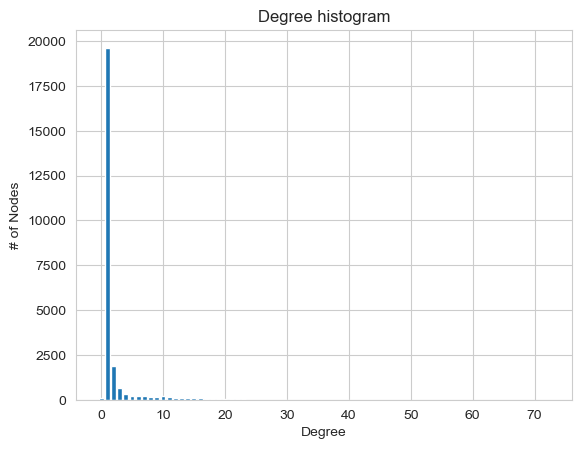

In [40]:
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree histogram")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")

plt.show()

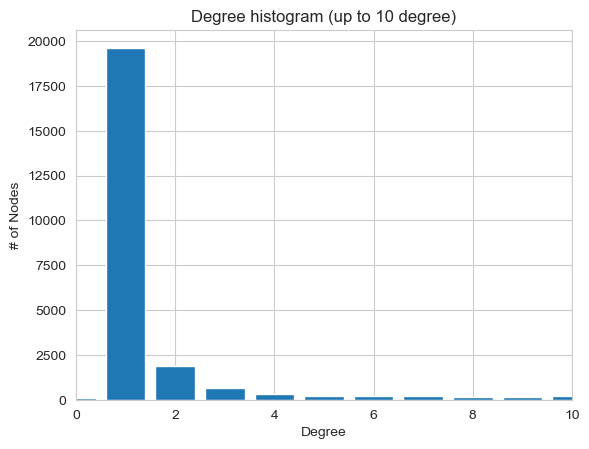

In [41]:
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree histogram (up to 10 degree)")
plt.xlabel("Degree")
plt.xlim(0,10)
plt.ylabel("# of Nodes")

plt.show()

From the histograms above, most nodes have a degree of 1. This is expected by the dataset which consists mostly of board members of charities, and it appears that majority of these members do not sit in multiple boards.

This provide a weakly connected network graph, which looks like dandelions in the above saved visualisations.

There is no clear indication in the SG donor landscape whether individual donors tend to only donate to a singulary or multiple charities.

For this project, we use this dataset as if the people connected to charities are the donors, to somewhat simulate possible donor personas based ont he board members.

In [42]:
node_with_highest_degree = max(G.nodes(), key=G.degree)

In [43]:
node_with_highest_degree

23140

In [44]:
G.nodes[node_with_highest_degree]

{'charity_uen': 'S87SS0113C',
 'charity_name': 'Hoon Hong Tian Haw Boo (Yun Feng Tian Hou Miao)',
 'address': '8 Ang Mo Kio Street 44, 569254',
 'postal_code': '569254',
 'charity_objective': 'to provide space for worship.',
 'charity_vision': nan,
 'sector': 'Religious',
 'is_ipc': 0,
 'activity_direct_services': 1,
 'activity_research': 0,
 'activity_financial_assistance': 0,
 'activity_support_charities': 0,
 'activity_grantmaking': 0,
 'activity_training_education': 0,
 'activity_public_awareness': 0,
 'classification_active_ageing': 0,
 'classification_animal_welfare': 0,
 'classification_buddhism': 0,
 'classification_central': 0,
 'classification_children/youth': 0,
 'classification_christianity': 0,
 'classification_cluster/hospital_funds': 0,
 'classification_community': 0,
 'classification_contemporary_&_ethnic_dance': 0,
 'classification_day_rehabilitation_centre': 0,
 'classification_disability_(adult)': 0,
 'classification_disability_(children)': 0,
 'classification_disabi

In [45]:
G.degree(node_with_highest_degree)

72

The earlier histogram showed a wide x axis. Investigating further found that the highest degree of a charity is 72 for this charity. From the data, it appears that they have listed the most patrons, which is rare for the dataset as most of the patron list is not updated.

In [46]:
charity_degrees = [G.degree(node) for node, data in G.nodes(data=True) if data.get('node-type') == 'entity']

In [47]:
# Create a dictionary to tabulate network findings for visualisation
dict_charities_vis = {
    'node': charity_nodes,
    'charity_name': charity_names,
    'charity_sector': charity_sectors,
    'degree': charity_degrees
}

In [48]:
df_charities_vis = pd.DataFrame.from_dict(dict_charities_vis)
df_charities_vis

node                              charity_name      charity_sector  \
0     22155                          #CHECKED LIMITED              Others   
1     22156                          *SCAPE CO., LTD.              Others   
2     22157                    =DREAMS (ASIA) LIMITED              Others   
3     22158               =DREAMS (SINGAPORE) LIMITED  Social and Welfare   
4     22159                            21C GIRLS LTD.           Education   
...     ...                                       ...                 ...   
2596  24751      Zion Living Streams Community Church           Religious   
2597  24752                  Zion Presbyterian Church           Religious   
2598  24753  ZION SERANGOON BIBLE-PRESBYTERIAN CHURCH           Religious   
2599  24754        Zonta Singapore- Project Pari Fund  Social and Welfare   
2600  24755                 Zu-Lin Temple Association           Religious   

      degree  
0          4  
1         13  
2          4  
3         14  
4          4  
...      ...  
2596      12  
2597      32  
2598       6  
2599       5  
2600      28  

[2601 rows x 4 columns]

Create a colour palette for each sector for sector based visualisations.

In [49]:
list_sectors = df_charities_vis['charity_sector'].unique()
list_sectors.sort()
list_sectors

array(['Arts and Heritage', 'Community', 'Education', 'Health', 'Others',
       'Religious', 'Social and Welfare', 'Sports'], dtype=object)

In [50]:
sector_palette = {}
for i, sector in enumerate(list_sectors):
    sector_palette[sector] = plt.cm.tab10.colors[i]

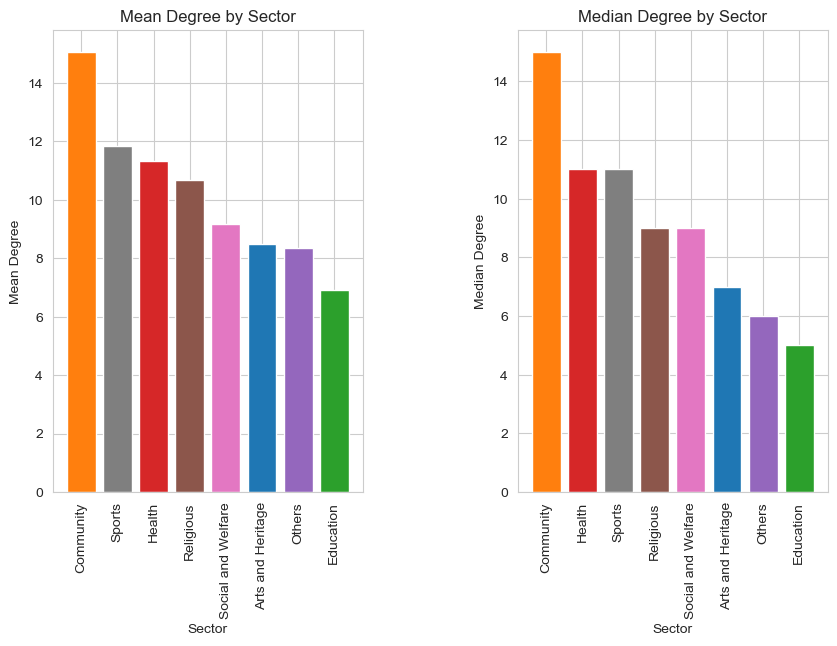

In [51]:
plt.figure(figsize=(10,6))
mean_degree_by_sector = df_charities_vis.groupby('charity_sector')['degree'].mean().reset_index().sort_values(by='degree', ascending=False)

color_palette = plt.cm.tab10.colors[:len(mean_degree_by_sector)]

plt.subplot(1, 2, 1)
plt.bar(mean_degree_by_sector['charity_sector'], mean_degree_by_sector['degree'], color=[sector_palette.get(x) for x in mean_degree_by_sector['charity_sector']])
plt.title("Mean Degree by Sector")
plt.xlabel("Sector")
plt.xticks(rotation=90)
plt.ylabel("Mean Degree")

median_degree_by_sector = df_charities_vis.groupby('charity_sector')['degree'].median().reset_index().sort_values(by='degree', ascending=False)

plt.subplot(1, 2, 2)
plt.bar(median_degree_by_sector['charity_sector'], median_degree_by_sector['degree'], color=[sector_palette.get(x) for x in median_degree_by_sector['charity_sector']])
plt.title("Median Degree by Sector")
plt.xlabel("Sector")
plt.xticks(rotation=90)
plt.ylabel("Median Degree")

plt.subplots_adjust(wspace=0.5)

plt.show()

Community sector charities are all Citizens' Consultative Committees (CCC) which supports locals constituencies. They have more board members listed than usual, hence the higher degree.

The remaining sectors are mostly in the same order for mean and median degrees.

### Centrality Visualisations

#### EigenCentrality

Using eigencentrality to measure the influence of charities in the network. Visualise the top 10 charities with the highest eigencentrality.

In [52]:
eig_centrality = nx.eigenvector_centrality(G)

In [53]:
sorted_eig_centrality = sorted(eig_centrality, key=eig_centrality.get, reverse=True)

In [54]:
charity_centrality = [eig_centrality[node] for node, data in G.nodes(data=True) if data.get('node-type') == 'entity']

In [55]:
df_charities_vis['centrality'] = charity_centrality

In [56]:
df_charities_vis

node                              charity_name      charity_sector  \
0     22155                          #CHECKED LIMITED              Others   
1     22156                          *SCAPE CO., LTD.              Others   
2     22157                    =DREAMS (ASIA) LIMITED              Others   
3     22158               =DREAMS (SINGAPORE) LIMITED  Social and Welfare   
4     22159                            21C GIRLS LTD.           Education   
...     ...                                       ...                 ...   
2596  24751      Zion Living Streams Community Church           Religious   
2597  24752                  Zion Presbyterian Church           Religious   
2598  24753  ZION SERANGOON BIBLE-PRESBYTERIAN CHURCH           Religious   
2599  24754        Zonta Singapore- Project Pari Fund  Social and Welfare   
2600  24755                 Zu-Lin Temple Association           Religious   

      degree    centrality  
0          4  1.283029e-06  
1         13  1.578501e-05  
2          4  4.787464e-07  
3         14  1.232032e-05  
4          4  9.368104e-05  
...      ...           ...  
2596      12  1.981311e-09  
2597      32  3.639387e-09  
2598       6  1.645581e-34  
2599       5  1.857901e-05  
2600      28  3.723954e-03  

[2601 rows x 5 columns]

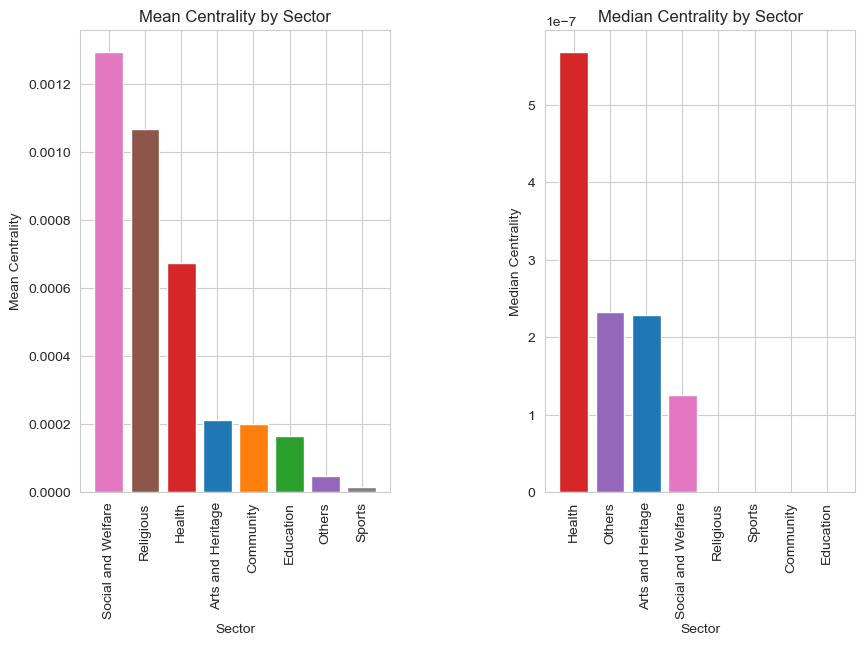

In [57]:
plt.figure(figsize=(10,6))

mean_centrality_by_sector = df_charities_vis.groupby('charity_sector')['centrality'].mean().reset_index().sort_values(by='centrality', ascending=False)

plt.subplot(1, 2, 1)
plt.bar(mean_centrality_by_sector['charity_sector'], mean_centrality_by_sector['centrality'], color=[sector_palette.get(x) for x in mean_centrality_by_sector['charity_sector']])
plt.title("Mean Centrality by Sector")
plt.xlabel("Sector")
plt.xticks(rotation=90)
plt.ylabel("Mean Centrality")


median_centrality_by_sector = df_charities_vis.groupby('charity_sector')['centrality'].median().reset_index().sort_values(by='centrality', ascending=False)

plt.subplot(1, 2, 2)
plt.bar(median_centrality_by_sector['charity_sector'], median_centrality_by_sector['centrality'], color=[sector_palette.get(x) for x in median_centrality_by_sector['charity_sector']])
plt.title("Median Centrality by Sector")
plt.xlabel("Sector")
plt.xticks(rotation=90)
plt.ylabel("Median Centrality")

plt.subplots_adjust(wspace=0.5)

plt.show()

In [58]:
df_charities_vis.groupby('charity_sector')['centrality'].median().reset_index().sort_values(by='centrality', ascending=False)

charity_sector    centrality
3              Health  5.686745e-07
4              Others  2.324634e-07
0   Arts and Heritage  2.286572e-07
6  Social and Welfare  1.254416e-07
5           Religious  6.358637e-11
7              Sports  3.757079e-11
1           Community  1.509634e-15
2           Education  5.147058e-20

In [59]:
df_charities_vis.groupby('charity_sector')['centrality'].mean().reset_index().sort_values(by='centrality', ascending=False)

charity_sector  centrality
6  Social and Welfare    0.001294
5           Religious    0.001067
3              Health    0.000672
0   Arts and Heritage    0.000213
1           Community    0.000200
2           Education    0.000165
4              Others    0.000046
7              Sports    0.000013

The median eigen centrality of Religious, Sports, Community and Education sector charities are observed to be very low. There also seems to be significant difference between the mean and median graphs.

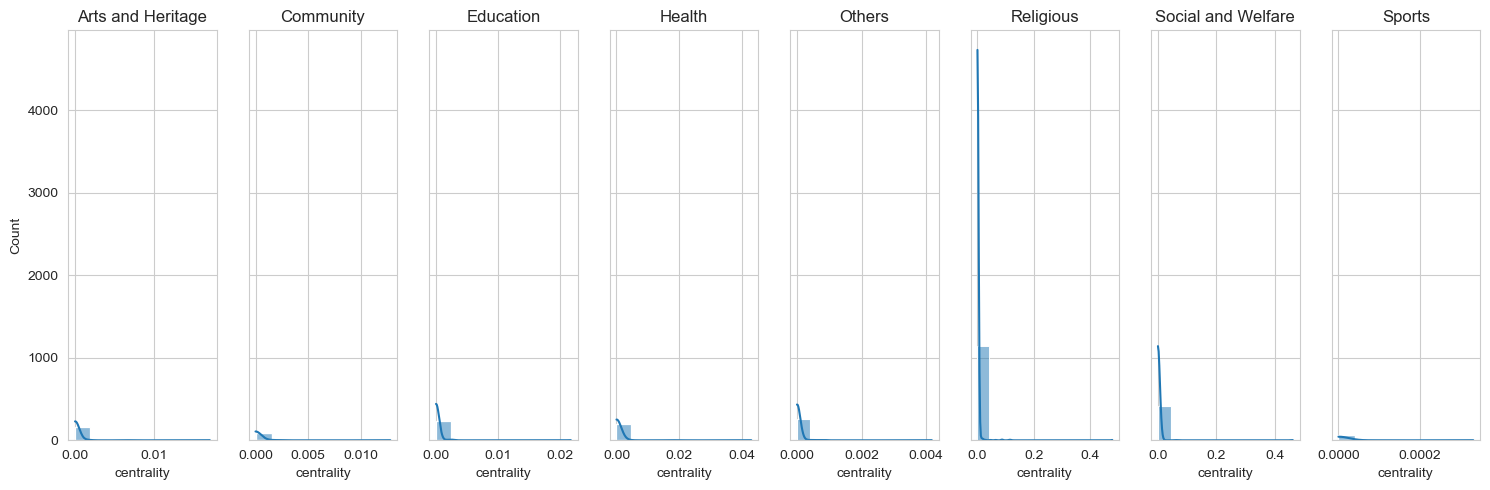

In [60]:
num_plots = 8

fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5), sharey=True)

for i, sector in enumerate(list_sectors):
    sector_data = df_charities_vis[df_charities_vis['charity_sector'] == sector]['centrality']
    sns.histplot(sector_data, ax=axes[i], kde=True, bins='sturges')
    axes[i].set_title(sector)

plt.tight_layout()
plt.show()

From further exploration, eigencentrality is not a meaningful measure for this dataset as the network is disconnected.

#### Forest Distance Closeness Centrality

Referencing to the [2019 IEEE International Conference on Data Mining (ICDM)](https://ieeexplore.ieee.org/document/8970897), an algorithm had been produced to cater for large networks that may be disconnected.

We use the NetworKit library insteada which implements and approximation of this algorithm for further exploration.

In [61]:
# Convert the NetworkX graph to NetworKit
G_nk = networkit.nxadapter.nx2nk(G)

In [62]:
# Creates a root node required to use the ForestCentrality
root_node = networkit.graphtools.augmentGraph(G_nk)
root_node

24756

In [63]:
forest_centrality = networkit.centrality.ForestCentrality(G_nk, root_node)

In [64]:
forest_centrality.run()

In [65]:
# As an additional root node was added, the score intended excludes the last node in this list
forest_centrality_score = forest_centrality.scores()[:-1]

In [66]:
charity_fcentrality = [forest_centrality_score[node] for node, data in G.nodes(data=True) if data.get('node-type') == 'entity']

In [67]:
df_charities_vis['fcentrality'] = charity_fcentrality

In [68]:
df_charities_vis.head()

node                 charity_name      charity_sector  degree  \
0  22155             #CHECKED LIMITED              Others       4   
1  22156             *SCAPE CO., LTD.              Others      13   
2  22157       =DREAMS (ASIA) LIMITED              Others       4   
3  22158  =DREAMS (SINGAPORE) LIMITED  Social and Welfare      14   
4  22159               21C GIRLS LTD.           Education       4   

     centrality  fcentrality  
0  1.283029e-06     1.243730  
1  1.578501e-05     1.648985  
2  4.787464e-07     1.316289  
3  1.232032e-05     1.699443  
4  9.368104e-05     1.278604

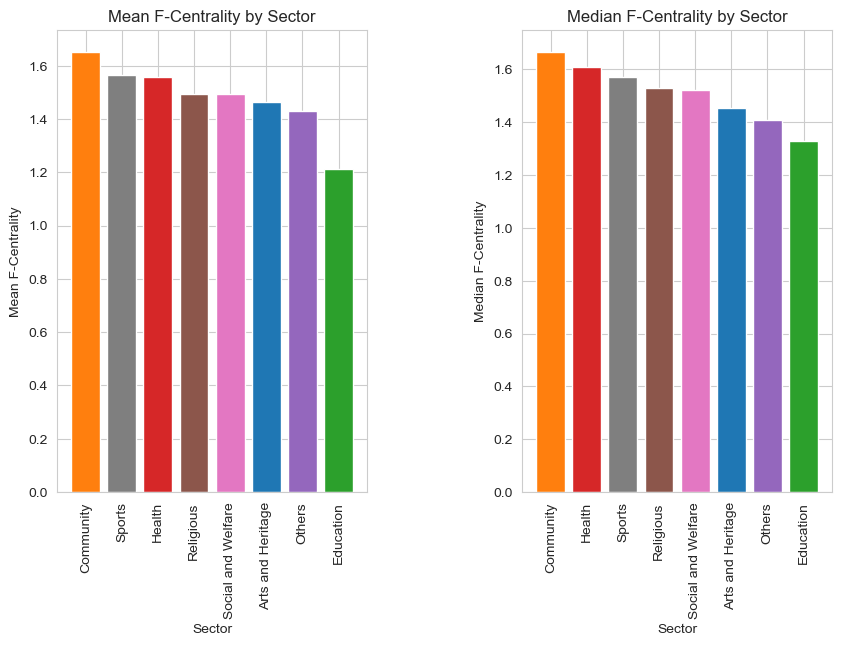

In [69]:
plt.figure(figsize=(10,6))

mean_centrality_by_sector = df_charities_vis.groupby('charity_sector')['fcentrality'].mean().reset_index().sort_values(by='fcentrality', ascending=False)

plt.subplot(1, 2, 1)
plt.bar(mean_centrality_by_sector['charity_sector'], mean_centrality_by_sector['fcentrality'], color=[sector_palette.get(x) for x in mean_centrality_by_sector['charity_sector']])
plt.title("Mean F-Centrality by Sector")
plt.xlabel("Sector")
plt.xticks(rotation=90)
plt.ylabel("Mean F-Centrality")


median_centrality_by_sector = df_charities_vis.groupby('charity_sector')['fcentrality'].median().reset_index().sort_values(by='fcentrality', ascending=False)

plt.subplot(1, 2, 2)
plt.bar(median_centrality_by_sector['charity_sector'], median_centrality_by_sector['fcentrality'], color=[sector_palette.get(x) for x in median_centrality_by_sector['charity_sector']])
plt.title("Median F-Centrality by Sector")
plt.xlabel("Sector")
plt.xticks(rotation=90)
plt.ylabel("Median F-Centrality")

plt.subplots_adjust(wspace=0.5)

plt.show()

The graphs for the forest distance closeness centrality is very similar to the graph of degree for each sector. The different measures of centrality on the whole network might not be meaningful as the network is large and disjoint. Thus, the importance or extent of influence may not be inferred at this scale across the entire network.

The centrality measures may be more applicable and interpretable when used in smaller subgraphs further down.

In [70]:
# central_charities_10 = [node for node in sorted_eig_centrality if G.nodes[node]['node-type'] == 'entity'][:10]

In [71]:
# central_charities_10

In [72]:
# central_charities_10_name = [G.nodes[node]['charity_name'] for node in central_charities_10]
# central_charities_10_name

In [73]:
# central_charities_10_degree = [G.degree(central_charities_10)[node] for node in central_charities_10]
# central_charities_10_degree

In [74]:
# central_charities_10_centrality = [eig_centrality[node] for node in central_charities_10]
# central_charities_10_centrality

---

## Part 4: Saving the Graph Data

Save the graph data (nodes and edges) as a JSON file

In [75]:
graph_data = json_graph.node_link_data(G)
with open('../json/graph.json', "w") as f:
    json.dump(graph_data, f, indent=4)